### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

1) MSE: $$-\frac{\partial L}{\partial a} = 2(y_i - a(x_i))$$
2) Экспоненциальная: $$-\frac{\partial L}{\partial a} = y_i e^{-a(x_i)y_i}$$
3) Логистическая: $$-\frac{\partial L}{\partial a} = \frac{y_i e^{-a(x_i)y_i}}{1 + e^{-a(x_i)y_i}} = \frac{y_i}{1 + e^{a(x_i)y_i}}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [313]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from random import sample

In [314]:
class MyGradientBoostingClassifier:

    def __init__(self, loss, learning_rate, n_estimators, colsample, subsample, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        colsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
    
    @staticmethod
    def __mse(y_true, y_pred):
        return 2 * (y_true - y_pred)
    
    @staticmethod
    def __exp(y_true, y_pred):
        return y_true * np.exp(-y_pred * y_true)
    
    @staticmethod
    def __log(y_true, y_pred):
        return y_true / (1 + np.exp(y_pred * y_true))
    
    def fit(self, X, y, base_model, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        if self.loss == 'mse':
            self.step_f = self.__mse
        elif self.loss == 'exponential':
            self.step_f = self.__exp
        elif self.loss == 'log':
            self.step_f = self.__log
            
        obj_size = np.around(self.subsample * X.shape[0]).astype(int)
        ft_size = np.around(self.colsample * X.shape[1]).astype(int)
        
        if init_model is None:
            y_pred = 0
            self.init_model = None
        else:
            initial_model = init_model()
            initial_model.fit(X, y)
            self.init_model = initial_model
            y_pred = self.init_model.predict(X)
            
        self.models = []
        self.ft = []
        for i in range(self.n_estimators):
            target = self.step_f(y, y_pred)
            obj = np.random.choice(X.shape[0], size=obj_size)
            ft = np.random.choice(X.shape[1], size=ft_size)
            model = base_model(*self.args, **self.kwargs).fit(X[obj[:, np.newaxis], ft], target[obj])
            y_pred += self.learning_rate * model.predict(X[:, ft])
            self.models.append(model)
            self.ft.append(ft)
            
        
    def predict(self, X):
        if self.init_model is None:
            y = 0
        else:
            y = self.init_model.predict(X)
        
        for model, ft in zip(self.models, self.ft):
            y += self.learning_rate * model.predict(X[:, ft])
        
        if self.loss == 'mse':
            return np.around(y).astype(int)
        else:
            return np.where(y>=0, 1, -1)
        


In [315]:
my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.1, n_estimators=10, colsample=1, subsample=1)
clf = GradientBoostingClassifier()

In [316]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [317]:
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [318]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [319]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [320]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [321]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [05:09<00:00, 28.14s/it]

best n: 41


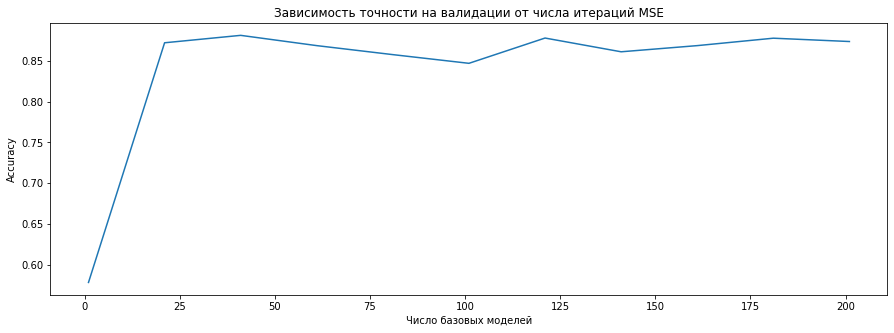

In [322]:
accuracy = []
for n in tqdm(range(1, 202, 20)):
    my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=0.1, n_estimators=n, colsample=1, subsample=1)
    my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
    
print(f'best n: {np.argmax(accuracy)*20+1}')

plt.figure(figsize=(15,5))
plt.title("Зависимость точности на валидации от числа итераций MSE")
plt.ylabel("Accuracy")
plt.xlabel("Число базовых моделей")

plt.plot(range(1, 202, 20), accuracy)

plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:51<00:00, 15.60s/it]

best n: 121


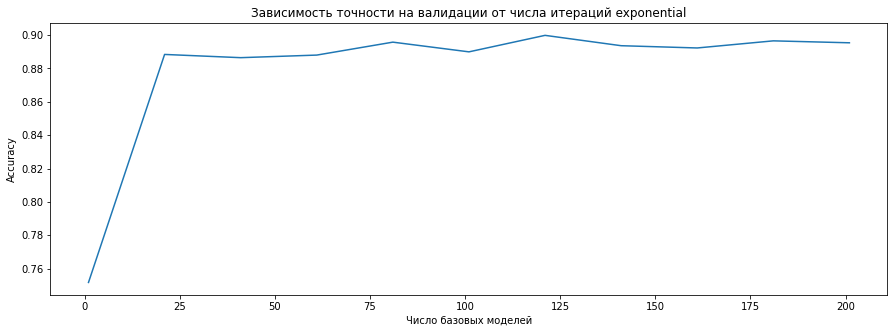

In [324]:
accuracy = []
for n in tqdm(range(1, 202, 20)):
    my_clf = MyGradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=n, colsample=1, subsample=1)
    my_clf.fit(X_train, y_train*2 - 1, base_model=DecisionTreeRegressor)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test*2 - 1))
print(f'best n: {np.argmax(accuracy)*20+1}')

plt.figure(figsize=(15,5))
plt.title("Зависимость точности на валидации от числа итераций exponential")
plt.ylabel("Accuracy")
plt.xlabel("Число базовых моделей")

plt.plot(range(1, 202, 20), accuracy)

plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [02:31<00:00, 13.78s/it]

best n: 141


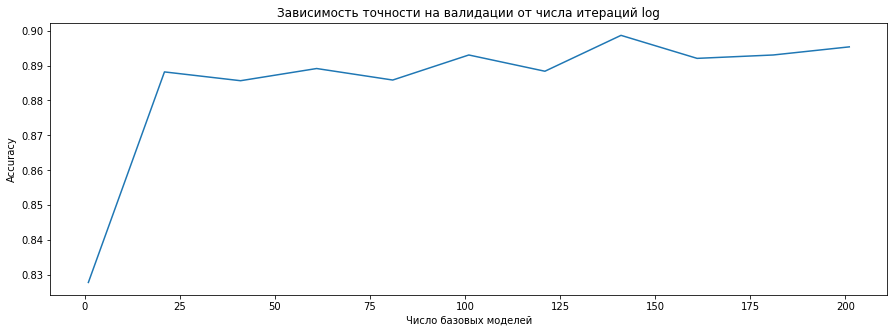

In [325]:
accuracy = []
for n in tqdm(range(1, 202, 20)):
    my_clf = MyGradientBoostingClassifier(loss='log', learning_rate=0.1, n_estimators=n, colsample=1, subsample=1)
    my_clf.fit(X_train, y_train*2 - 1, base_model=DecisionTreeRegressor)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test*2 - 1))
    
print(f'best n: {np.argmax(accuracy)*20+1}')

plt.figure(figsize=(15,5))
plt.title("Зависимость точности на валидации от числа итераций log")
plt.ylabel("Accuracy")
plt.xlabel("Число базовых моделей")

plt.plot(range(1, 202, 20), accuracy)

plt.show()

In [326]:
params_grid = pd.DataFrame(columns=['loss', 'colsample', 'subsample', 'learning_rate', 'accuracy'])
for loss in tqdm(['mse', 'exponential', 'log']):
    for colsample in [0.4, 0.6, 0.8, 1.0]:
        for subsample in [0.4, 0.6, 0.8, 1.0]:
            for learning_rate in [0.1, 0.05, 0.01]:
                my_clf = MyGradientBoostingClassifier(n_estimators=30, loss=loss, 
                                                      colsample=colsample, subsample=subsample, learning_rate=learning_rate)
                if loss=='mse':
                    my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
                    y_pred = my_clf.predict(X_test)
                    acc = accuracy_score(y_pred, y_test)
                else:
                    my_clf.fit(X_train, y_train*2-1, base_model=DecisionTreeRegressor)
                    y_pred = my_clf.predict(X_test)
                    acc = accuracy_score(y_pred, y_test*2-1)
                
                result = pd.DataFrame({'loss': [loss], 'colsample': [colsample], 
                                        'subsample': [subsample], 'learning_rate': [learning_rate], 'accuracy':[acc]}) 
                params_grid = pd.concat([params_grid, result],  ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:58<00:00, 99.66s/it]


In [327]:
params_grid[params_grid['accuracy'] == params_grid['accuracy'].max()]

,loss,colsample,subsample,learning_rate,accuracy
135,log,1.0,0.6,0.1,0.895736


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [328]:
from sklearn.ensemble import RandomForestRegressor

##### BooBag

In [329]:
my_clf = MyGradientBoostingClassifier(loss='log', learning_rate=0.1, colsample=1.0, subsample=0.6, n_estimators=30)
my_clf.fit(X_train, y_train * 2 - 1, base_model=RandomForestRegressor)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test * 2 - 1))

0.8868217054263566


#### BagBoo

In [330]:
N = 10
models = []
for i in range(N):
    idx = np.random.randint(0, X_train.shape[0], X_train.shape[0])
    my_clf = MyGradientBoostingClassifier(loss='log', learning_rate=0.1, colsample=1.0, subsample=0.6, n_estimators=30)
    my_clf.fit(X_train[idx, :], (y_train * 2 - 1)[idx], base_model=DecisionTreeRegressor)
    models.append(my_clf)

In [331]:
y_pred = np.zeros(X_test.shape[0])
for model in models:
    y_pred += model.predict(X_test)
    
y_pred = np.where(y_pred >= 0, 1, -1)
print(accuracy_score(y_pred, y_test * 2 - 1))

0.888953488372093


## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [309]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [333]:
for init_model in [SVR, LinearRegression, RandomForestRegressor]:
    my_clf = MyGradientBoostingClassifier(loss='log', learning_rate=0.1, colsample=1.0, subsample=0.6, n_estimators=30)
    my_clf.fit(X_train, (y_train * 2 - 1), base_model=DecisionTreeRegressor, init_model=init_model)
    
    print(f'Accuracy для {init_model.__name__}: {accuracy_score(my_clf.predict(X_test), y_test * 2 - 1)}.')

Accuracy для SVR: 0.8428294573643411.
Accuracy для LinearRegression: 0.8891472868217054.
Accuracy для RandomForestRegressor: 0.887015503875969.


## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

